In [2]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class clean_features(BaseEstimator, TransformerMixin):
    """
    Remove features with more than 10% missing values

    Returns: list of features to keep
    """
    def __init__(self):
        self.to_keep_ = []

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # Remove descriptors with >10% missing values
        missing_counts = X.isna().sum()
        valid_features = missing_counts[missing_counts <= len(X) * 0.1].index.tolist()
        self.to_keep_ = valid_features

        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        X_filtered = X[self.to_keep_].copy()
        return X_filtered


In [3]:
class remove_correlated_features(BaseEstimator, TransformerMixin):
    """
    Remove highly correlated features from a DataFrame.

    For each pair with |correlation| > threshold, removes the
    feature with higher mean absolute correlation to all others.

    Parameters:
    - threshold: correlation threshold (default 0.95)

    Returns: list of features to keep
    """
    def __init__(self, threshold = 0.95):
        self.threshold = threshold
        self.to_drop_ = []

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # Calculate correlation matrix
        corr_matrix = X.corr().abs()

        target_corr = X.corrwith(y).abs()

        # Get upper triangle (avoid duplicate pairs)
        upper_tri = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )

        for col in upper_tri.columns:
            # Find features correlated above threshold with this column
            correlated = upper_tri.index[upper_tri[col] > self.threshold].tolist()
            for corr_feat in correlated:
                # Keep feature with lower mean correlation
                if target_corr[col] > target_corr[corr_feat]:
                    self.to_drop_.append(corr_feat)
                else:
                    self.to_drop_.append(col)
        self.to_drop_ = list(set(self.to_drop_))
        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        kept_columns = [c for c in X.columns if c not in self.to_drop_]
        X_filtered = X[kept_columns].copy()
        return X_filtered


In [6]:
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, SelectFromModel, VarianceThreshold

In [4]:
def mi_reproducible(X, y):
    return mutual_info_regression(X, y, random_state=42)

In [7]:
import pandas as pd
import joblib

train_fp = pd.read_csv("splits/DATASET_fingerprints_combined_train.csv")
test_fp = pd.read_csv("splits/DATASET_fingerprints_combined_test.csv")
best_model = joblib.load("models/optimised_SVR_CombinedFP.joblib")

In [8]:
best_model.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('clean', clean_features()),
                                 ('imputer',
                                  SimpleImputer(fill_value=0,
                                                strategy='constant')),
                                 ('var', VarianceThreshold(threshold=0.001)),
                                 ('select',
                                  SelectKBest(k=572,
                                              score_func=<function mi_reproducible at 0x1251de3b0>)),
                                 ('scaler', MaxAbsScaler())])),
                ('model', SVR(C=3.322164520503593, epsilon=0.105149152121402))])>

In [17]:
best_model.named_steps['preprocess']

,steps,"[('clean', ...), ('imputer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'constant'
,fill_value,0
,copy,True
,add_indicator,False
,keep_empty_features,False
,threshold,0.001


In [25]:
import numpy as np

target_col = "pIC50"
metadata_cols=['molecule_chembl_id', 'smiles', 'pIC50']
# 1. Get names after the cleaning step (assuming it doesn't change names, just drops them)
# If clean_features just drops columns, find out which ones are left:
original_cols = [c for c in train_fp.columns if c not in metadata_cols]
cols_after_clean = original_cols # Replace this if your clean step actually renames things

# 2. Skip 'clean' and 'imputer' and get names from 'var' (VarianceThreshold)
# We access the fitted VarianceThreshold step directly
var_threshold_step = best_model['preprocess']['var']
mask_var = var_threshold_step.get_support()
names_after_var = np.array(cols_after_clean)[mask_var]

# 3. Now apply the 'select' (SelectKBest) mask to those names
selector_step = best_model['preprocess']['select']
mask_select = selector_step.get_support()

final_selected_features = names_after_var[mask_select]
print(len(final_selected_features))

572


In [26]:
X_train = train_fp[original_cols]
y_train = train_fp[target_col]
X_test = test_fp[original_cols]
y_test = test_fp[target_col]

In [27]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def evaluate_model(y_true, y_pred, set_name=''):
    """Calculate and display regression metrics."""
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    if set_name:
        print(f"{set_name:12} R²={r2:.3f}  RMSE={rmse:.3f}  MAE={mae:.3f}")
    
    return {'R2': r2, 'RMSE': rmse, 'MAE': mae}
 
# Verify loaded model performance
_ = evaluate_model(y_train, best_model.predict(X_train), 'Train')
baseline_test = evaluate_model(y_test, best_model.predict(X_test), 'Test')
 
print(f"\n[OK] Model loaded successfully and produces expected predictions.")


Train        R²=0.885  RMSE=0.400  MAE=0.257
Test         R²=0.702  RMSE=0.612  MAE=0.482

[OK] Model loaded successfully and produces expected predictions.


In [ ]:
from scipy import stats
 
def comprehensive_evaluation(y_true, y_pred):
    """
    Calculate comprehensive regression metrics for QSAR validation.
    """
    n = len(y_true)
    
    # Basic metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Pearson and Spearman correlations
    pearson_r, pearson_p = stats.pearsonr(y_true, y_pred)
    spearman_r, spearman_p = stats.spearmanr(y_true, y_pred)
    
    # Bias (mean error)
    bias = np.mean(y_pred - y_true)
    
    # Concordance correlation coefficient (CCC)
    # Measures both precision and accuracy
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    covar = np.cov(y_true, y_pred)[0, 1]
    ccc = (2 * covar) / (var_true + var_pred + (mean_true - mean_pred)**2)
    
    return {
        'n': n,
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'pearson': pearson_r,
        'spearman': spearman_r,
        'bias': bias,
        'ccc': ccc
    }
 
# Evaluate on external test set
y_pred_test = best_model.predict(X_test)
test_metrics = comprehensive_evaluation(y_test, y_pred_test)
 
print("EXTERNAL TEST SET EVALUATION")
print("Model: SVR CombinedFP Optimized ")
print("=" * 50)
print(f"n (test compounds):     {test_metrics['n']}")
print(f"R²:                     {test_metrics['R2']:.4f}")
print(f"RMSE:                   {test_metrics['RMSE']:.4f}")
print(f"MAE:                    {test_metrics['MAE']:.4f}")
print(f"Pearson r:              {test_metrics['pearson']:.4f}")
print(f"Spearman r:             {test_metrics['spearman']:.4f}")
print(f"Bias:                   {test_metrics['bias']:.4f}")
print(f"CCC:                    {test_metrics['ccc']:.4f}")


EXTERNAL TEST SET EVALUATION
Model: SVR Optimized 
n (test compounds):     85
R²:                     0.7025
RMSE:                   0.6123
MAE:                    0.4818
Pearson r:              0.8456
Spearman r:             0.7890
Bias:                   -0.1109
CCC:                    0.8282


In [29]:
def golbraikh_tropsha_criteria(y_true, y_pred):
    """
    Evaluate Golbraikh-Tropsha validation criteria for QSAR models.
    
    Criteria:
    1. q² > 0.5
    2. r² > 0.6
    3. |r² - r0²| < 0.1 or |r² - r'0²| < 0.1
    4. 0.85 <= k <= 1.15 or 0.85 <= k' <= 1.15
    5. |r0² - r'0²| < 0.3
    """
    n = len(y_true)
    
    # r² (standard R²)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate slope k (y_pred vs y_true, forced through origin)
    k = np.sum(y_true * y_pred) / np.sum(y_pred ** 2)
    
    # Calculate slope k' (y_true vs y_pred, forced through origin)
    k_prime = np.sum(y_true * y_pred) / np.sum(y_true ** 2)
    
    # r0² (R² with regression line forced through origin)
    y_pred_scaled = k * y_pred
    ss_res = np.sum((y_true - y_pred_scaled) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r0_sq = 1 - ss_res / ss_tot
    
    # r'0² (reversed regression through origin)
    y_true_scaled = k_prime * y_true
    ss_res_prime = np.sum((y_pred - y_true_scaled) ** 2)
    ss_tot_prime = np.sum((y_pred - np.mean(y_pred)) ** 2)
    r0_prime_sq = 1 - ss_res_prime / ss_tot_prime
    
    # Evaluate criteria
    criteria = {
        'r2': r2,
        'r0_sq': r0_sq,
        'r0_prime_sq': r0_prime_sq,
        'k': k,
        'k_prime': k_prime,
        'criterion_1': r2 > 0.6,
        'criterion_2': (abs(r2 - r0_sq) < 0.1) or (abs(r2 - r0_prime_sq) < 0.1),
        'criterion_3': (0.85 <= k <= 1.15) or (0.85 <= k_prime <= 1.15),
        'criterion_4': abs(r0_sq - r0_prime_sq) < 0.3
    }
    
    return criteria


In [30]:
# Evaluate Golbraikh-Tropsha criteria
gt_results = golbraikh_tropsha_criteria(y_test, y_pred_test)
 
print("GOLBRAIKH-TROPSHA VALIDATION CRITERIA")
print("Model: Random Forest (FP) Baseline")
print("=" * 50)
print(f"r²:       {gt_results['r2']:.4f}")
print(f"r0²:      {gt_results['r0_sq']:.4f}")
print(f"r'0²:     {gt_results['r0_prime_sq']:.4f}")
print(f"k:        {gt_results['k']:.4f}")
print(f"k':       {gt_results['k_prime']:.4f}")
print()
print("Criteria Assessment:")
print(f"  1. r² > 0.6:                    {'PASS' if gt_results['criterion_1'] else 'FAIL'}")
print(f"  2. |r² - r0²| or |r² - r'0²| < 0.1: {'PASS' if gt_results['criterion_2'] else 'FAIL'}")
print(f"  3. 0.85 ≤ k or k' ≤ 1.15:       {'PASS' if gt_results['criterion_3'] else 'FAIL'}")
print(f"  4. |r0² - r'0²| < 0.3:          {'PASS' if gt_results['criterion_4'] else 'FAIL'}")
print("=" * 50)
 
all_pass = all([gt_results['criterion_1'], gt_results['criterion_2'],
                gt_results['criterion_3'], gt_results['criterion_4']])
if all_pass:
    print("\n[PASS] Model satisfies all Golbraikh-Tropsha criteria.")
else:
    print("\n[WARNING] Model fails one or more Golbraikh-Tropsha criteria.")


GOLBRAIKH-TROPSHA VALIDATION CRITERIA
Model: Random Forest (FP) Baseline
r²:       0.7025
r0²:      0.7135
r'0²:     0.5640
k:        1.0181
k':       0.9742

Criteria Assessment:
  1. r² > 0.6:                    PASS
  2. |r² - r0²| or |r² - r'0²| < 0.1: PASS
  3. 0.85 ≤ k or k' ≤ 1.15:       PASS
  4. |r0² - r'0²| < 0.3:          PASS

[PASS] Model satisfies all Golbraikh-Tropsha criteria.


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
 
def y_randomization_test(X, y, pipeline, n_iterations=100, cv=5):

    np.random.seed(42)
    
    # Calculate original model performance via CV
    original_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2')
    original_r2 = original_scores.mean()
    
    # Perform randomization iterations
    randomized_r2_values = []
    
    for i in range(n_iterations):
        # Shuffle y values
        y_shuffled = np.random.permutation(y)

        # Create a fresh, unfitted copy of the entire pipeline
        fresh_pipeline = clone(pipeline)
        
        # Train and evaluate on shuffled data
        scores = cross_val_score(fresh_pipeline, X, y_shuffled, cv=cv, scoring='r2')
        randomized_r2_values.append(scores.mean())
        
        if (i + 1) % 20 == 0:
            print(f"  Completed {i + 1}/{n_iterations} iterations...")
    
    return {
        'original_r2': original_r2,
        'randomized_r2_values': randomized_r2_values,
        'randomized_mean': np.mean(randomized_r2_values),
        'randomized_std': np.std(randomized_r2_values),
    }


In [42]:
from sklearn.svm import SVR


# Run Y-randomization test using same parameters as the loaded model
print("Running Y-randomization test (30 iterations)...")
print("This will take several minutes.\n")

y_rand_results = y_randomization_test(
    X_train, y_train,
    best_model,
    n_iterations=30,
    cv=5
)


Running Y-randomization test (30 iterations)...
This will take several minutes.

  Completed 20/30 iterations...


In [43]:
# Calculate statistical significance
z_score = (y_rand_results['original_r2'] - y_rand_results['randomized_mean']) / y_rand_results['randomized_std']

# Calculate how many randomized R² values exceed the original
n_exceed = sum(r2 >= y_rand_results['original_r2'] for r2 in y_rand_results['randomized_r2_values'])
p_value = n_exceed / len(y_rand_results['randomized_r2_values'])

# Calculate max for the check below
randomized_max = max(y_rand_results['randomized_r2_values'])

print(f"\nStatistical Analysis:")
print(f"  Z-score: {z_score:.2f}")
print(f"  p-value: {p_value:.4f}")

if z_score > 3 and randomized_max < y_rand_results['original_r2']:
    print(f"\n[PASS] Model significantly outperforms random (z > 3)")
    print(f"  The model has learned genuine structure-activity relationships.")
else:
    print(f"\n[WARNING] Model may be exploiting chance correlations")
    print(f"  Review your data and model for potential issues.")



Statistical Analysis:
  Z-score: 17.97
  p-value: 0.0000

[PASS] Model significantly outperforms random (z > 3)
  The model has learned genuine structure-activity relationships.


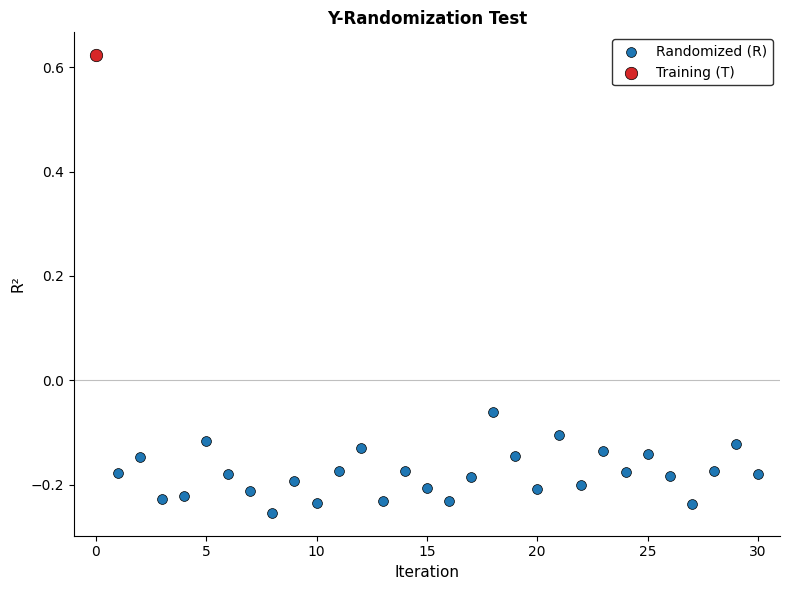

<Figure size 640x480 with 0 Axes>

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

# Plot randomized R² values
iterations = range(1, len(y_rand_results['randomized_r2_values']) + 1)
ax.scatter(iterations, y_rand_results['randomized_r2_values'], 
           color='#1f77b4', s=50, edgecolor='black', linewidth=0.5, 
           label='Randomized (R)', zorder=3)

# Plot original model R² at position 0
ax.scatter(0, y_rand_results['original_r2'], color='#d62728', s=80, 
           edgecolor='black', linewidth=0.5, label='Training (T)', zorder=3)

# Reference lines
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)

# Formatting
ax.set_xlabel('Iteration', fontsize=11)
ax.set_ylabel('R²', fontsize=11)
ax.set_title('Y-Randomization Test', fontsize=12, fontweight='bold')
ax.legend(frameon=True, edgecolor='black', fontsize=10)
ax.set_xlim(-1, len(y_rand_results['randomized_r2_values']) + 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
plt.savefig('figures/y_randomization_test.png', dpi=300, bbox_inches='tight')


In [45]:
def bootstrap_confidence_intervals(y_true, y_pred, n_bootstrap=10, ci=95):   #n_boostrap should be 1000 in real projects  
    """
    Calculate bootstrap confidence intervals for regression metrics.
    """
    np.random.seed(42)
    n = len(y_true)
    
    metrics_boot = {'R2': [], 'RMSE': [], 'MAE': [], 'Pearson_r': []}
    
    for _ in range(n_bootstrap):
        # Sample with replacement
        idx = np.random.choice(n, size=n, replace=True)
        y_true_boot = y_true[idx]
        y_pred_boot = y_pred[idx]
        
        # Calculate metrics
        metrics_boot['R2'].append(r2_score(y_true_boot, y_pred_boot))
        metrics_boot['RMSE'].append(np.sqrt(mean_squared_error(y_true_boot, y_pred_boot)))
        metrics_boot['MAE'].append(mean_absolute_error(y_true_boot, y_pred_boot))
        metrics_boot['Pearson_r'].append(stats.pearsonr(y_true_boot, y_pred_boot)[0])
    
    # Calculate confidence intervals
    alpha = (100 - ci) / 2
    results = {}
    
    for metric, values in metrics_boot.items():
        values = np.array(values)
        results[metric] = {
            'mean': np.mean(values),
            'std': np.std(values),
            'ci_lower': np.percentile(values, alpha),
            'ci_upper': np.percentile(values, 100 - alpha)
        }
    
    return results


In [ ]:
# Calculate bootstrap confidence intervals
print("Calculating bootstrap confidence intervals (1000 iterations)...")
boot_ci = bootstrap_confidence_intervals(y_test, y_pred_test, n_bootstrap=1000)
 
print("\nBOOTSTRAP CONFIDENCE INTERVALS (95%)")
print("Model: SVR CombinedFP Optimized ")
print("=" * 60)
print(f"{'Metric':<12} {'Mean':>10} {'95% CI Lower':>14} {'95% CI Upper':>14}")
print("-" * 60)
 
for metric in ['R2', 'RMSE', 'MAE', 'Pearson_r']:
    data = boot_ci[metric]
    print(f"{metric:<12} {data['mean']:>10.4f} {data['ci_lower']:>14.4f} {data['ci_upper']:>14.4f}")
 
print("=" * 60)


Calculating bootstrap confidence intervals (1000 iterations)...

BOOTSTRAP CONFIDENCE INTERVALS (95%)
Model: Random Forest (FP) Baseline
Metric             Mean   95% CI Lower   95% CI Upper
------------------------------------------------------------
R2               0.6899         0.5603         0.7900
RMSE             0.6138         0.5194         0.7038
MAE              0.4841         0.4084         0.5667
Pearson_r        0.8409         0.7630         0.8987


In [50]:
# Generate comprehensive validation report
print("="*70)
print("QSAR MODEL VALIDATION REPORT")
print("="*70)
print(f"Model: SVR Combined FP - Optimized")
print(f"Target: pIC50")
print(f"Features: Combined fingerprints (Before feature selection) ({X_train.shape[1]})")
print(f"Features: Combined fingerprints (After feature selection) ({len(final_selected_features)})")
print(f"Split method: Scaffold-based (Bemis-Murcko)")
print()
print("DATASET SUMMARY")
print("-"*70)
print(f"Training set:   {len(y_train):>6,} compounds")
print(f"Test set:       {len(y_test):>6,} compounds")
print()
print("Y-RANDOMIZATION TEST")
print("-"*70)
print(f"Original R² (CV):    {y_rand_results['original_r2']:.4f}")
print(f"Randomized R² mean:  {y_rand_results['randomized_mean']:.4f}")
print(f"Z-score:             {z_score:.2f}")
print(f"Status:              {'PASS' if z_score > 3 else 'FAIL'}")
print()
print("EXTERNAL TEST SET PERFORMANCE (with 95% CI)")
print("-"*70)
for metric in ['R2', 'RMSE', 'MAE']:
    ci = boot_ci[metric]
    print(f"{metric}:  {ci['mean']:.4f} [{ci['ci_lower']:.4f} - {ci['ci_upper']:.4f}]")
print()
print("GOLBRAIKH-TROPSHA CRITERIA")
print("-"*70)
criteria_names = ['r² > 0.6', '|r² - r0²| < 0.1', '0.85 ≤ k ≤ 1.15', '|r0² - r\'0²| < 0.3']
criteria_results = [gt_results['criterion_1'], gt_results['criterion_2'],
                    gt_results['criterion_3'], gt_results['criterion_4']]
for name, result in zip(criteria_names, criteria_results):
    print(f"{name:30} {'PASS' if result else 'FAIL'}")
print()
print("="*70)


QSAR MODEL VALIDATION REPORT
Model: SVR Combined FP - Optimized
Target: pIC50
Features: Combined fingerprints (Before feature selection) (4263)
Features: Combined fingerprints (After feature selection) (572)
Split method: Scaffold-based (Bemis-Murcko)

DATASET SUMMARY
----------------------------------------------------------------------
Training set:      337 compounds
Test set:           85 compounds

Y-RANDOMIZATION TEST
----------------------------------------------------------------------
Original R² (CV):    0.6230
Randomized R² mean:  -0.1790
Z-score:             17.97
Status:              PASS

EXTERNAL TEST SET PERFORMANCE (with 95% CI)
----------------------------------------------------------------------
R2:  0.6899 [0.5603 - 0.7900]
RMSE:  0.6138 [0.5194 - 0.7038]
MAE:  0.4841 [0.4084 - 0.5667]

GOLBRAIKH-TROPSHA CRITERIA
----------------------------------------------------------------------
r² > 0.6                       PASS
|r² - r0²| < 0.1               PASS
0.85 ≤ k ≤ 

In [51]:
# Save validation report to file
report_lines = []
report_lines.append("QSAR MODEL VALIDATION REPORT")
report_lines.append("=" * 60)
report_lines.append(f"Model: SVR Combined FP - Optimized")
report_lines.append(f"Date: {pd.Timestamp.now().strftime('%Y-%m-%d')}")
report_lines.append("")
report_lines.append(f"Test R²: {boot_ci['R2']['mean']:.4f} [95% CI: {boot_ci['R2']['ci_lower']:.4f}-{boot_ci['R2']['ci_upper']:.4f}]")
report_lines.append(f"Test RMSE: {boot_ci['RMSE']['mean']:.4f} [95% CI: {boot_ci['RMSE']['ci_lower']:.4f}-{boot_ci['RMSE']['ci_upper']:.4f}]")
report_lines.append(f"Y-randomization Z-score: {z_score:.2f}")
report_lines.append(f"All Golbraikh-Tropsha criteria: {'PASS' if all_pass else 'FAIL'}")

with open('reports/REPORT_validation_report.txt', 'w') as f:
    f.write('\n'.join(report_lines))

print("\nValidation report saved to: REPORT_validation_report.txt")



Validation report saved to: REPORT_validation_report.txt


In [52]:
# Store SMILES for later use
train_smiles = train_fp['smiles'].values
test_smiles = test_fp['smiles'].values

In [59]:
import shap
import tqdm
import numpy as np
import pandas as pd

# 1. Identify your features
all_features = X_train.columns.tolist()
# Define only the features you want to EXPLAIN (the rest will stay at median)
selected_indices = [all_features.index(f) for f in final_selected_features]

print(f"Initializing SHAP for {len(final_selected_features)} selected features...")

# 2. Create the wrapper function
# KernelExplainer will only "wiggle" the features in x_subset.
# We map those back into a full array so the Pipeline doesn't crash.
median_background = X_train.median().values.reshape(1, -1)

def model_predict_subset(x_subset):
    # Create a base matrix of medians the size of the current SHAP batch
    full_input = np.tile(median_background, (x_subset.shape[0], 1))
    # Overlay the features SHAP is actually testing
    full_input[:, selected_indices] = x_subset
    # Convert to DataFrame if your pipeline expects named columns
    full_input_df = pd.DataFrame(full_input, columns=all_features)
    return best_model.predict(full_input_df)


background_summary = shap.kmeans(X_train[final_selected_features], 20)
background_robust = background_summary.data

# PermutationExplainer is generally faster than KernelExplainer
print("Initializing PermutationExplainer...")
explainer = shap.Explainer(model_predict_subset, background_robust)

print("Computing SHAP values (Optimized)...")
# We use the explainer object directly (it's the newer SHAP API)
num_features = len(final_selected_features)
min_evals = 2 * num_features + 1
print(f"Running SHAP for {num_features} features. Min evals required: {min_evals}")

print("Computing SHAP values (limited to selected features)...")
# We only pass the selected columns from the test set
shap_results = explainer(
    X_test[final_selected_features], 
    max_evals=min_evals + 10
)

shap_values_test = shap_results.values

print(f"Done! SHAP shape: {shap_values_test.shape}")

Initializing SHAP for 572 selected features...
Initializing PermutationExplainer...
Computing SHAP values (Optimized)...
Running SHAP for 572 features. Min evals required: 1145
Computing SHAP values (limited to selected features)...


PermutationExplainer explainer: 86it [04:40,  3.33s/it]                        

Done! SHAP shape: (85, 572)


In [60]:
# --- 4. TRAINING SET CALCULATION (Adapted for n=337 & New API) ---
print(f"\nComputing SHAP for the full Training Set ({len(X_train)} compounds)...")

# We use the full training set (only the selected features)
X_train_sample = X_train[final_selected_features]

# We run the explainer on the whole training block at once.
# The new API handles the looping internally and works with tqdm if enabled.
shap_results_train = explainer(
    X_train_sample, 
    max_evals=min_evals + 50
)
# Extract the values into the array for your importance ranking code
shap_values_train = shap_results_train.values

print(f"Done! Training SHAP shape: {shap_values_train.shape}")


Computing SHAP for the full Training Set (337 compounds)...


PermutationExplainer explainer: 338it [17:00,  3.06s/it]                         

Done! Training SHAP shape: (337, 572)


In [61]:
# Calculate mean absolute SHAP value for each feature
mean_shap_importance = np.abs(shap_values_train).mean(axis=0)
 
# Create DataFrame of feature importance
feature_importance_df = pd.DataFrame({
    'feature': final_selected_features,
    'importance': mean_shap_importance
}).sort_values('importance', ascending=False)
 
print("TOP 20 MOST IMPORTANT FEATURES (by mean |SHAP|)")
print("=" * 50)
print(f"{'Rank':<6} {'Feature':<20} {'Mean |SHAP|':>12}")
print("-" * 50)
 
for i, (_, row) in enumerate(feature_importance_df.head(20).iterrows()):
    print(f"{i+1:<6} {row['feature']:<20} {row['importance']:>12.4f}")
 
print("=" * 50)


TOP 20 MOST IMPORTANT FEATURES (by mean |SHAP|)
Rank   Feature               Mean |SHAP|
--------------------------------------------------
1      ECFP4_984                  0.0698
2      RDKit_1561                 0.0600
3      RDKit_848                  0.0598
4      RDKit_1398                 0.0590
5      RDKit_281                  0.0528
6      RDKit_442                  0.0423
7      MACCS_66                   0.0380
8      RDKit_1041                 0.0374
9      RDKit_756                  0.0353
10     ECFP4_1984                 0.0346
11     RDKit_105                  0.0296
12     RDKit_119                  0.0293
13     RDKit_1851                 0.0290
14     RDKit_115                  0.0288
15     RDKit_1316                 0.0285
16     RDKit_84                   0.0281
17     RDKit_969                  0.0276
18     RDKit_1524                 0.0273
19     ECFP4_199                  0.0273
20     RDKit_1207                 0.0257


/var/folders/pw/3sg0trmd0q5fjprkktw_29y00000gn/T/ipykernel_2442/3139983671.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


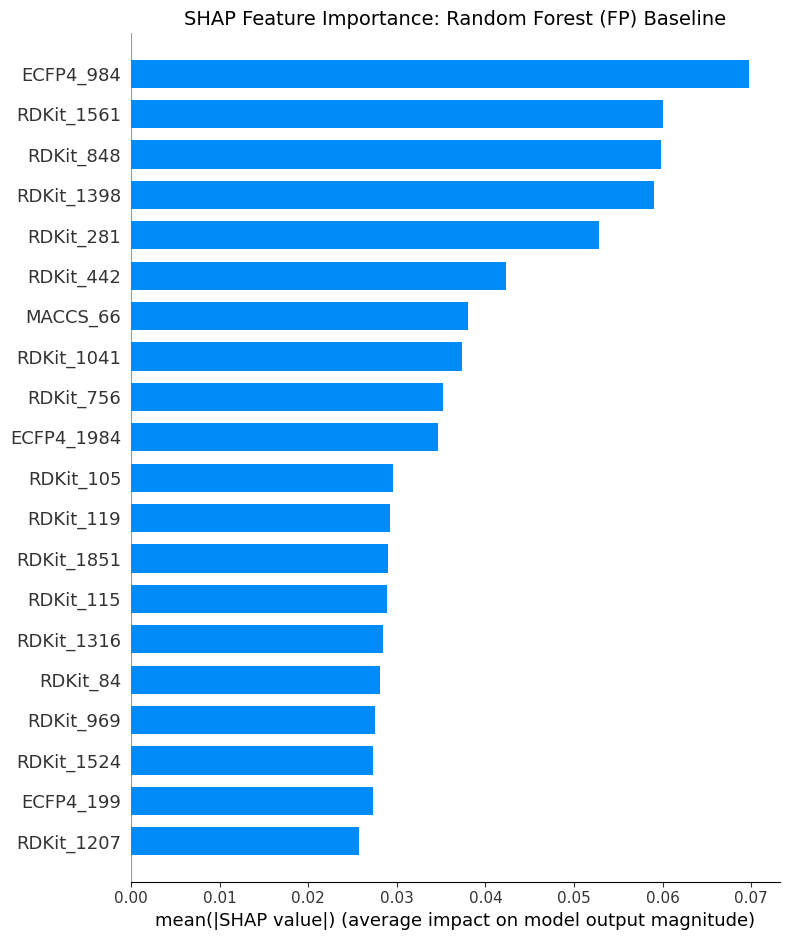

In [62]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(
    shap_values_train,
    X_train_sample,
    feature_names=final_selected_features,
    max_display=20,
    plot_type="bar",   # single aggregated bar plot across all classes
    show=False
)
plt.title('SHAP Feature Importance: Random Forest (FP) Baseline', fontsize=14)
plt.tight_layout()
plt.savefig('figures/shap_summary_plot.png', dpi=150, bbox_inches='tight')
plt.show()


In [63]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from collections import defaultdict
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

def get_ecfp_bit_info(smiles_list, radius=2, n_bits=2048):
    """
    Extract bit information for ECFP fingerprints.
    Returns a mapping of bit index to (SMILES, atom_idx, radius) tuples.
    """
    bit_info_all = defaultdict(list)
    
    for smiles in smiles_list[:100]:  # Sample for efficiency
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
        
        bit_info = {}
        fp = AllChem.GetMorganFingerprintAsBitVect(
            mol, radius=radius, nBits=n_bits, bitInfo=bit_info
        )
        
        for bit_idx, atoms_radii in bit_info.items():
            for atom_idx, rad in atoms_radii:
                bit_info_all[bit_idx].append((smiles, atom_idx, rad))
    
    return bit_info_all
 
# Get bit information from training compounds
print("Extracting ECFP bit information from training compounds...")
bit_info = get_ecfp_bit_info(train_smiles.tolist())
print(f"Mapped {len(bit_info)} unique bits to molecular substructures.")


Extracting ECFP bit information from training compounds...
Mapped 669 unique bits to molecular substructures.


In [64]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import display, HTML
import io

def visualize_bit_substructure(bit_idx, bit_info_dict):
    if bit_idx not in bit_info_dict:
        return None, None, None, None, None

    for smi, atom_idx, radius in bit_info_dict[bit_idx]:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue

        env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
        atom_map = {}
        submol = Chem.PathToSubmol(mol, env, atomMap=atom_map)

        if submol.GetNumAtoms() > 0:
            highlight_atoms = list(atom_map.keys())
            highlight_bonds = list(env)
            return mol, submol, highlight_atoms, highlight_bonds, smi

    return None, None, None, None, None

print("\nTop Most Important ECFP Bits and Their Substructures:")
print("=" * 60)

top_bits = feature_importance_df.head(10)['feature'].tolist()
visualized_count = 0
svg_cells = []

for bit_name in top_bits:
    if visualized_count >= 6:  # 2 rows x 3 cols
        break

    try:
        bit_idx = int(bit_name.split('_')[-1])
    except:
        continue

    result = visualize_bit_substructure(bit_idx, bit_info)
    if result[0] is not None:
        mol, submol, highlight_atoms, highlight_bonds, smi = result
        importance = feature_importance_df[
            feature_importance_df['feature'] == bit_name
        ]['importance'].values[0]

        Chem.rdDepictor.Compute2DCoords(mol)

        drawer = rdMolDraw2D.MolDraw2DSVG(350, 300)
        drawer.drawOptions().addAtomIndices = False

        atom_colors = {a: (1.0, 0.7, 0.3) for a in highlight_atoms}
        bond_colors = {b: (1.0, 0.7, 0.3) for b in highlight_bonds}
        atom_radii = {a: 0.4 for a in highlight_atoms}

        drawer.DrawMolecule(
            mol,
            highlightAtoms=highlight_atoms,
            highlightBonds=highlight_bonds,
            highlightAtomColors=atom_colors,
            highlightBondColors=bond_colors,
            highlightAtomRadii=atom_radii,
        )
        drawer.FinishDrawing()
        svg = drawer.GetDrawingText().replace("svg:", "")

        sub_smi = Chem.MolToSmiles(submol)
        caption = f"<b>Bit {bit_idx}</b> (imp: {importance:.4f})<br>{sub_smi}"
        svg_cells.append(f'<td style="text-align:center; padding:10px;">{svg}<br>{caption}</td>')
        visualized_count += 1

# Build HTML table with 3 columns
ncols = 3
html = '<table style="border-collapse: collapse;">'
for i in range(0, len(svg_cells), ncols):
    html += '<tr>' + ''.join(svg_cells[i:i+ncols]) + '</tr>'
html += '</table>'

display(HTML(html))



Top Most Important ECFP Bits and Their Substructures:


In [67]:
def explain_prediction(idx, X, y_true, y_pred, shap_values, feature_names, smiles=None):
    """
    Generate detailed explanation for a single prediction.
    """
    print(f"\nPREDICTION EXPLANATION (Test compound #{idx})")
    print("=" * 60)
    
    if smiles is not None:
        print(f"SMILES: {smiles[:60]}..." if len(smiles) > 60 else f"SMILES: {smiles}")
    
    print(f"True pIC50:      {y_true[idx]:.2f}")
    print(f"Predicted pIC50: {y_pred[idx]:.2f}")
    print(f"Error:           {y_pred[idx] - y_true[idx]:.2f}")
    print()
    
    # Get SHAP values for this compound
    shap_vals = shap_values[idx]
    
    # Sort by absolute SHAP value
    sorted_idx = np.argsort(np.abs(shap_vals))[::-1]
    
    print("Top 10 features influencing this prediction:")
    print(f"{'Feature':<20} {'Value':>8} {'SHAP':>10} {'Direction':>12}")
    print("-" * 55)
    
    for i in sorted_idx[:10]:
        feat_name = feature_names[i]
        feat_val = X[idx, i]
        shap_val = shap_vals[i]
        direction = '↑ potency' if shap_val > 0 else '↓ potency'
        print(f"{feat_name:<20} {feat_val:>8.0f} {shap_val:>10.4f} {direction:>12}")
    
    print("=" * 60)
 
# Get predictions
y_pred_test = best_model.predict(X_test)
 
# Explain predictions for compounds with best, worst, and median predictions
sorted_by_pred = np.argsort(y_pred_test)
 
# Convert X_test to values for the function to handle indexing easily
X_test_values = X_test[final_selected_features].values

# Most potent prediction (The 'Winner')
explain_prediction(
    sorted_by_pred[-1], 
    X_test_values, 
    y_test.values, # Ensure y is also an array
    y_pred_test,
    shap_values_test, 
    final_selected_features, 
    test_smiles[sorted_by_pred[-1]] # Use .iloc if smiles is a Series
)

# Least potent prediction (The 'Loser')
explain_prediction(
    sorted_by_pred[0], 
    X_test_values, 
    y_test.values, 
    y_pred_test,
    shap_values_test, 
    final_selected_features, 
    test_smiles[sorted_by_pred[0]]
)



PREDICTION EXPLANATION (Test compound #8)
SMILES: CCc1c(F)ccc2cc(O)cc(-c3ncc4c(N5CC(O)CC6(CC6)C5)nc(OC[C@@]56C...
True pIC50:      8.85
Predicted pIC50: 8.94
Error:           0.09

Top 10 features influencing this prediction:
Feature                 Value       SHAP    Direction
-------------------------------------------------------
ECFP4_199                   1     0.1241    ↑ potency
ECFP4_494                   1     0.1204    ↑ potency
RDKit_1851                  1     0.0919    ↑ potency
RDKit_848                   1     0.0640    ↑ potency
ECFP4_984                   0     0.0618    ↑ potency
RDKit_442                   1     0.0588    ↑ potency
RDKit_407                   1     0.0585    ↑ potency
RDKit_756                   1     0.0555    ↑ potency
RDKit_297                   1     0.0546    ↑ potency
ECFP4_216                   1     0.0513    ↑ potency

PREDICTION EXPLANATION (Test compound #60)
SMILES: O=C1N[C@H](c2c(CNCc3ccc4ccn(Cc5ccccc5)c4c3)[nH]c3ccccc23)c2c...
True pI

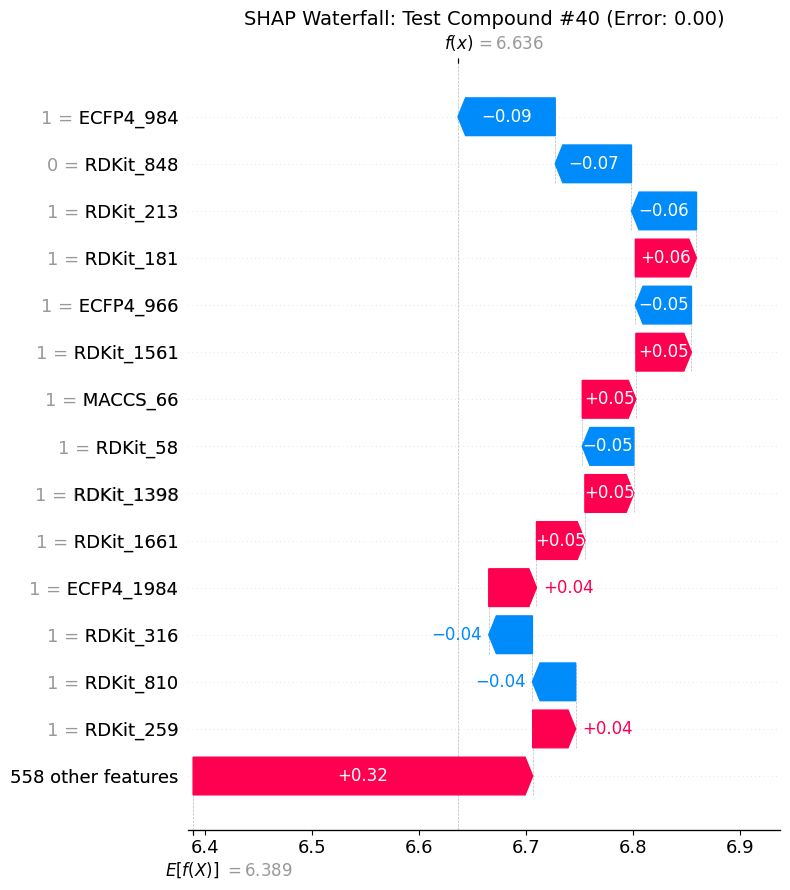

In [70]:
import matplotlib.pyplot as plt

# 1. Select a compound with good prediction accuracy
# Ensure y_test is treated as an array for the subtraction
errors = np.abs(y_pred_test - np.array(y_test))
good_pred_idx = np.argmin(errors)

# 2. Create the Waterfall Plot using the results object directly
plt.figure(figsize=(12, 8))

# We slice the shap_results object directly: shap_results[index]
# This automatically carries the correct base_value, data, and values
shap.plots.waterfall(shap_results[good_pred_idx], max_display=15, show=False)

plt.title(f'SHAP Waterfall: Test Compound #{good_pred_idx} (Error: {errors[good_pred_idx]:.2f})', fontsize=14)
plt.tight_layout()
plt.show()

In [71]:
import os

# Create interpretation directory
os.makedirs('interpretation', exist_ok=True)

# Save feature importance
feature_importance_df.to_csv('interpretation/DATASET_shap_feature_importance.csv', index=False)

# Save test predictions
pred_df = pd.DataFrame({
    'smiles': test_smiles,
    'y_true': y_test,
    'y_pred': y_pred_test,
})
pred_df.to_csv('interpretation/DATASET_test_predictions.csv', index=False)

# Save SHAP values
np.save('interpretation/DATASET_shap_values_test.npy', shap_values_test)